In [4]:
import re
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

log_root = "/data1/home/jw1017/GLAS_Dock/GLAS-Dock/main_repo/lightning_logs"

pattern = re.compile(r"best-epoch=(\d+(?:\.\d+)?)-val_loss=.*\.ckpt$")

def find_best_ckpt(path):
    ckpts = glob.glob(os.path.join(path, "best-epoch=*-val_loss=*-val_as_acc=*.ckpt"))
    if not ckpts:
        return None
    parsed = []
    for c in ckpts:
        m = pattern.search(os.path.basename(c))
        if m:
            epoch = float(m.group(1))
            parsed.append((epoch, c))
    if not parsed:
        return None
    parsed.sort(key=lambda x: x[0], reverse=True)
    return parsed[0][1]

def get_df(benchmark, version):

    log_name = f"benchmark_experiment_{benchmark}"

    ckpts = [find_best_ckpt(f"{log_root}/{log_name}/version_{version}/checkpoints") for version in range(version, version+5)]

    descriptives = [pd.read_csv(ckpt[:-5]+'_descriptive.csv').reset_index(drop=True) for ckpt in ckpts]
    descriptives[0]

    # Merge descriptives
    df = pd.concat(descriptives).reset_index(drop=True)
    # Drop first column if it's unnamed or not
    if df.columns[0] == 'Unnamed: 0' or not df.columns[0]:
        df = df.drop(df.columns[0], axis=1)
    
    return df

def get_predictions(benchmark, version):

    log_name = f"benchmark_experiment_{benchmark}"

    ckpts = [find_best_ckpt(f"{log_root}/{log_name}/version_{version}/checkpoints") for version in range(version, version+5)]

    descriptives = [pd.read_csv(ckpt[:-5]+'_predicted_scores.csv').reset_index(drop=True) for ckpt in ckpts]
    descriptives[0]

    # Merge descriptives
    df = pd.concat(descriptives).reset_index(drop=True)
    # Drop first column if it's unnamed or not
    if df.columns[0] == 'Unnamed: 0' or not df.columns[0]:
        df = df.drop(df.columns[0], axis=1)
    
    return df

In [ ]:
df_posexsd = get_df(benchmark='posex_self_docking', version=5)
df_pred_posexsd = get_predictions(benchmark='posex_self_docking', version=5)
df_posexcd = get_df(benchmark='posex_cross_docking', version=5)
df_pred_posexcd = get_predictions(benchmark='posex_cross_docking', version=5)
df_moad = get_df(benchmark='moad', version=5)
df_pred_moad = get_predictions(benchmark='moad', version=5)
df_astex_posex = get_df(benchmark='astex_posex', version=219)
df_pred_astex_posex = get_predictions(benchmark='astex_posex', version=219)
df_posebusters = get_df(benchmark='posebusters', version=20)
df_pred_posebusters = get_predictions(benchmark='posebusters', version=20)

In [ ]:
print("Length of the benchmarks")
print('MOAD: ', len(df_moad))
print('PoseX + Astex: ', len(df_astex_posex))
print('PoseBusters: ', len(df_posebusters))

Length of the benchmarks
MOAD:  3179
PoseX + Astex:  2114
PoseBusters:  428


/tmp/ipykernel_3368855/891508429.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Paired", 5)


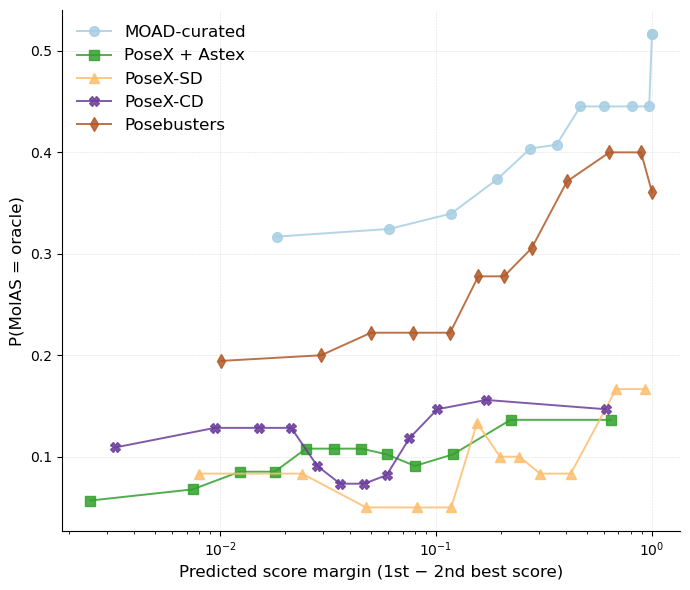

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.signal import medfilt

def plot_reliability_curve(
    df: pd.DataFrame,
    df_pred: pd.DataFrame,
    benchmark_label,
    n_bins: int = 12,
    ax=None,
    color=None,
    marker: str = "o",
):
    """
    Reliability: Probability that MolAS = oracle as a function of margin.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    algo_score_cols = df.columns[2:-7]

    scores = df_pred[algo_score_cols].to_numpy()
    sorted_scores = np.sort(scores, axis=1)[:, ::-1]
    as_score = sorted_scores[:, 0]
    second = sorted_scores[:, 1]

    # Normalised margin
    margin = (as_score - second) / (np.abs(as_score) + np.abs(second) + 1e-6)
    # margin = (as_score - second) / (np.abs(as_score) + np.abs(second) + 1e-6)
    correct = (df["AS"] == df["oracle"]).astype(float)

    # Equal-mass quantile bins
    edges = np.quantile(margin, np.linspace(0, 1, n_bins + 1))
    centers = 0.5 * (edges[:-1] + edges[1:])
    acc = [
        correct[(margin >= lo) & (margin <= hi)].mean()
        if np.any((margin >= lo) & (margin <= hi))
        else np.nan
        for lo, hi in zip(edges[:-1], edges[1:])
    ]
    
    acc_smooth = medfilt(acc, kernel_size=3)

    # Plot
    ax.plot(
        centers, acc_smooth,
        marker=marker,
        markersize=7,
        linewidth=1.4,
        label=benchmark_label,
        color=color,
        alpha=0.85,
        zorder=3,
    )

    # lo, hi = bootstrap_ci([correct[(margin >= lo) & (margin <= hi)] for lo, hi in zip(edges[:-1], edges[1:]) if np.any((margin >= lo) & (margin <= hi))])
    # ax.fill_between([centers], [lo], [hi], alpha=0.1, color=color)

    # Aesthetics
    # ax.set_xlim(min(centers), max(centers))
    # ax.set_ylim(0, 1)
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
    ax.set_xlabel("Predicted score margin (1st − 2nd best score)", fontsize=12)
    ax.set_ylabel(f"P(MolAS = oracle)", fontsize=12)
    ax.set_xscale('log')

    return ax

fig, ax = plt.subplots(figsize=(7, 6))
cmap = get_cmap("Paired", 5)

plot_reliability_curve(df_moad, df_pred_moad, "MOAD-curated", ax=ax, color=cmap(0), marker="o")
plot_reliability_curve(df_astex_posex, df_pred_astex_posex, "PoseX + Astex", ax=ax, color=cmap(1), marker="s")
plot_reliability_curve(df_posexsd, df_pred_posexsd, "PoseX-SD", ax=ax, color=cmap(2), marker="^")
plot_reliability_curve(df_posexcd, df_pred_posexcd, "PoseX-CD", ax=ax, color=cmap(3), marker="X")
plot_reliability_curve(df_posebusters, df_pred_posebusters, "Posebusters", ax=ax, color=cmap(4), marker="d")
# ax.set_title("Algorithm-selection reliability curves", fontsize=11)
ax.legend(frameon=False, fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# plt.show()
plt.savefig("reliability_curves.pdf")

/tmp/ipykernel_3368855/1803951374.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Paired", 5)
/tmp/ipykernel_3368855/1803951374.py:96: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1)


SBS: unimol
SBS: surfdock_relaxation
SBS: surfdock_relaxation
SBS: surfdock_relaxation
SBS: autodock
SBS: unimol
SBS: surfdock_relaxation
SBS: surfdock_relaxation
SBS: surfdock_relaxation
SBS: autodock


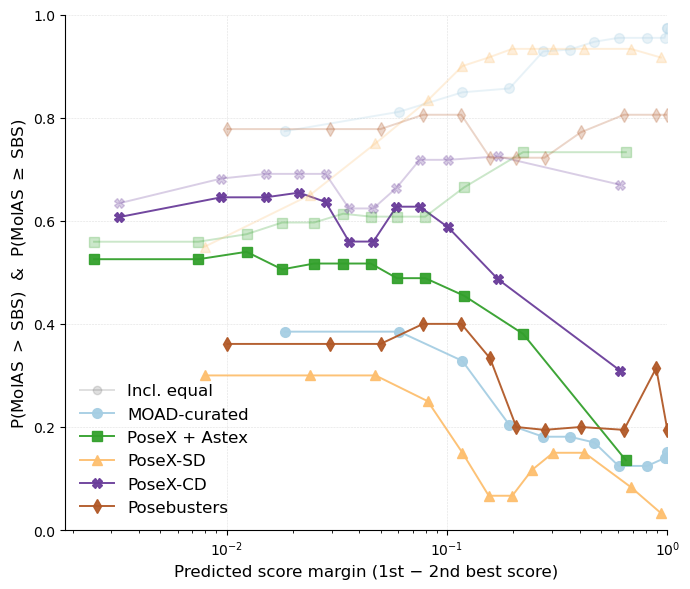

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.signal import medfilt

def plot_reliability_curve(
    df: pd.DataFrame,
    df_pred: pd.DataFrame,
    benchmark_label,
    n_bins: int = 12,
    ax=None,
    color=None,
    incl_equal: bool = False,
    alpha: float = 0.95,
    label: bool = True,
    marker: str = "o",
):
    """
    Reliability: Probability that MolAS = oracle as a function of margin.
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    algo_score_cols = df.columns[2:-7]

    scores = df_pred[algo_score_cols].to_numpy()
    sorted_scores = np.sort(scores, axis=1)[:, ::-1]
    as_score = sorted_scores[:, 0]
    second = sorted_scores[:, 1]

    sbs_col_name = df.columns[-6]
    print(sbs_col_name)

    # Normalised margin
    margin = (as_score - second) / (np.abs(as_score) + np.abs(second) + 1e-6)
    # margin = (as_score - second) / (np.abs(as_score) + np.abs(second) + 1e-6)
    if incl_equal:
        correct = (df["AS"] >= df[sbs_col_name]).astype(float)
    else:
        correct = (df["AS"] > df[sbs_col_name]).astype(float)

    # Equal-mass quantile bins
    edges = np.quantile(margin, np.linspace(0, 1, n_bins + 1))
    centers = 0.5 * (edges[:-1] + edges[1:])
    acc = [
        correct[(margin >= lo) & (margin <= hi)].mean()
        if np.any((margin >= lo) & (margin <= hi))
        else np.nan
        for lo, hi in zip(edges[:-1], edges[1:])
    ]
    
    acc_smooth = medfilt(acc, kernel_size=3)
    
    if not label:
        benchmark_label = None
    # Plot
    ax.plot(
        centers, acc_smooth,
        marker=marker,
        markersize=7,
        linewidth=1.4,
        label=benchmark_label,
        color=color,
        alpha=alpha,
        zorder=3,
    )

    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
    ax.set_xlabel("Predicted score margin (1st − 2nd best score)", fontsize=12)
    ax.set_ylabel(f"P(MolAS $>$ SBS)  &  P(MolAS $\geq$ SBS)", fontsize=12)
    ax.set_xscale('log')

    return ax

fig, ax = plt.subplots(figsize=(7, 6))
cmap = get_cmap("Paired", 5)

# Add a legend entry for the faded lines
ax.plot([], [], marker="o", markersize=6, linewidth=1.4, color="gray", alpha=0.25, label="Incl. equal")

plot_reliability_curve(df_moad, df_pred_moad, "MOAD-curated", ax=ax, color=cmap(0), marker="o")
plot_reliability_curve(df_astex_posex, df_pred_astex_posex, "PoseX + Astex", ax=ax, color=cmap(1), marker="s")
plot_reliability_curve(df_posexsd, df_pred_posexsd, "PoseX-SD", ax=ax, color=cmap(2), marker="^")
plot_reliability_curve(df_posexcd, df_pred_posexcd, "PoseX-CD", ax=ax, color=cmap(3), marker="X")
plot_reliability_curve(df_posebusters, df_pred_posebusters, "Posebusters", ax=ax, color=cmap(4), marker="d")

plot_reliability_curve(df_moad, df_pred_moad, "MOAD-curated", ax=ax, color=cmap(0), incl_equal=True, alpha=0.25, label=False, marker="o")
plot_reliability_curve(df_astex_posex, df_pred_astex_posex, "PoseX + Astex", ax=ax, color=cmap(1), incl_equal=True, alpha=0.25, label=False, marker="s")
plot_reliability_curve(df_posexsd, df_pred_posexsd, "PoseX-SD", ax=ax, color=cmap(2), incl_equal=True, alpha=0.25, label=False, marker="^")
plot_reliability_curve(df_posexcd, df_pred_posexcd, "PoseX-CD", ax=ax, color=cmap(3), incl_equal=True, alpha=0.25, label=False, marker="X")
plot_reliability_curve(df_posebusters, df_pred_posebusters, "Posebusters", ax=ax, color=cmap(4), incl_equal=True, alpha=0.25, label=False, marker="d")

# ax.set_title("Algorithm-selection reliability curves", fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(frameon=False, fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# plt.show()
plt.savefig("outperformance_curves.pdf")

In [ ]:
import torch

def get_features(benchmark, version):

    log_name = f"benchmark_experiment_{benchmark}"

    ckpts = [find_best_ckpt(f"{log_root}/{log_name}/version_{version}/checkpoints") for version in range(version, version+5)]

    names = []
    features = []

    for ckpt in ckpts:

        data = torch.load(ckpt[:-5]+'_embedded_features.pt')

        names += data['names']
        features.append(data['features'])

    # Merge features
    features = np.concatenate(features, axis=0)
    
    return names, features

names_posexsd, X_posexsd = get_features(benchmark='posex_self_docking', version=5)
names_posexcd, X_posexcd = get_features(benchmark='posex_cross_docking', version=5)
names_moad, X_moad = get_features(benchmark='moad', version=5)
names_astex_posex, X_astex_posex = get_features(benchmark='astex_posex', version=219)
names_posebusters, X_posebusters = get_features(benchmark='posebusters', version=20)

/tmp/ipykernel_3368855/2023680625.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(ckpt[:-5]+'_embedded_features.pt')


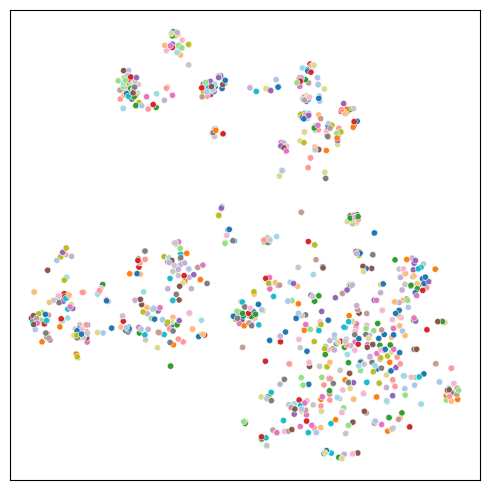

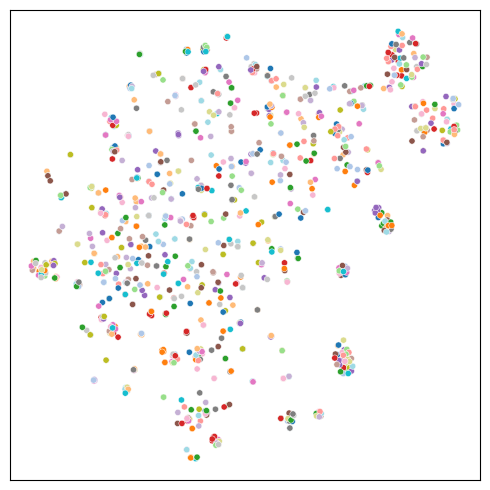

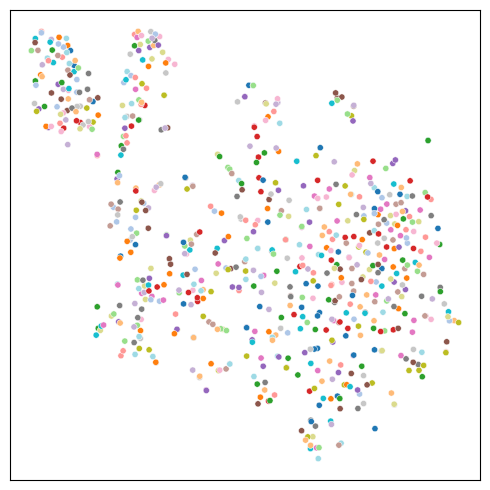

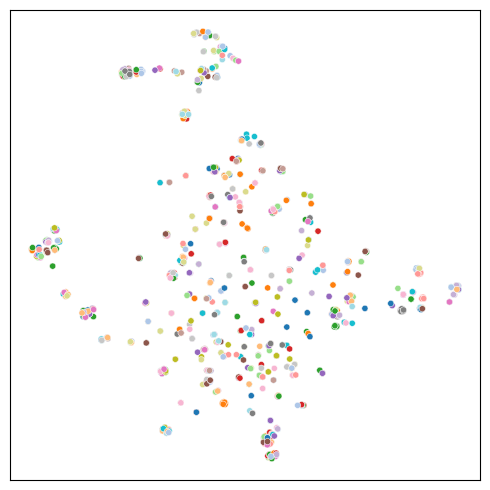

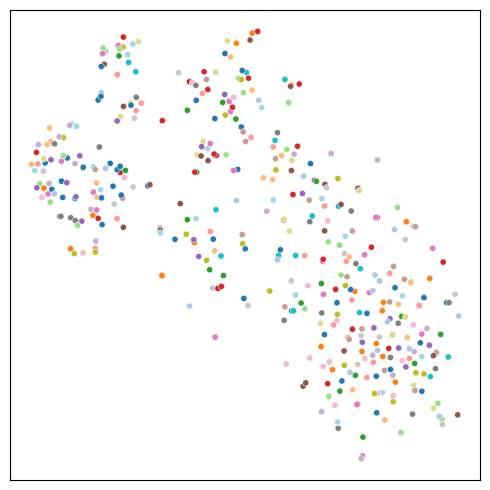

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_tsne(
    X,
    df,
    title,
    color_field="oracle",
    n_pca=50,
    max_points=1000,
    random_state=0,
):
    X = np.asarray(X, dtype=np.float32)

    # Subsample for clarity
    if X.shape[0] > max_points:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(X.shape[0], max_points, replace=False)
        X_use = X[idx]
        df_use = df.iloc[idx].reset_index(drop=True)
    else:
        X_use = X
        df_use = df

    # PCA → t-SNE
    X_pca = PCA(n_components=min(n_pca, X_use.shape[1])).fit_transform(X_use)
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init="pca",
        random_state=random_state,
    )
    Y = tsne.fit_transform(X_pca)

    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        x=Y[:, 0],
        y=Y[:, 1],
        hue=df_use[color_field],
        s=20,
        palette="tab20",
        legend=False,
    )
    # plt.title(f"t-SNE ({title})")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"tsne_{title.lower()}.pdf")

visualize_tsne(X_moad, df_moad, title="MC-GNNAS-Dock")
visualize_tsne(X_astex_posex, df_astex_posex, title="Astex + PoseX")
visualize_tsne(X_posexsd, df_posexsd, title="PoseX-SD")
visualize_tsne(X_posexcd, df_posexcd, title="PoseX-CD")
visualize_tsne(X_posebusters, df_posebusters, title="Posebusters")

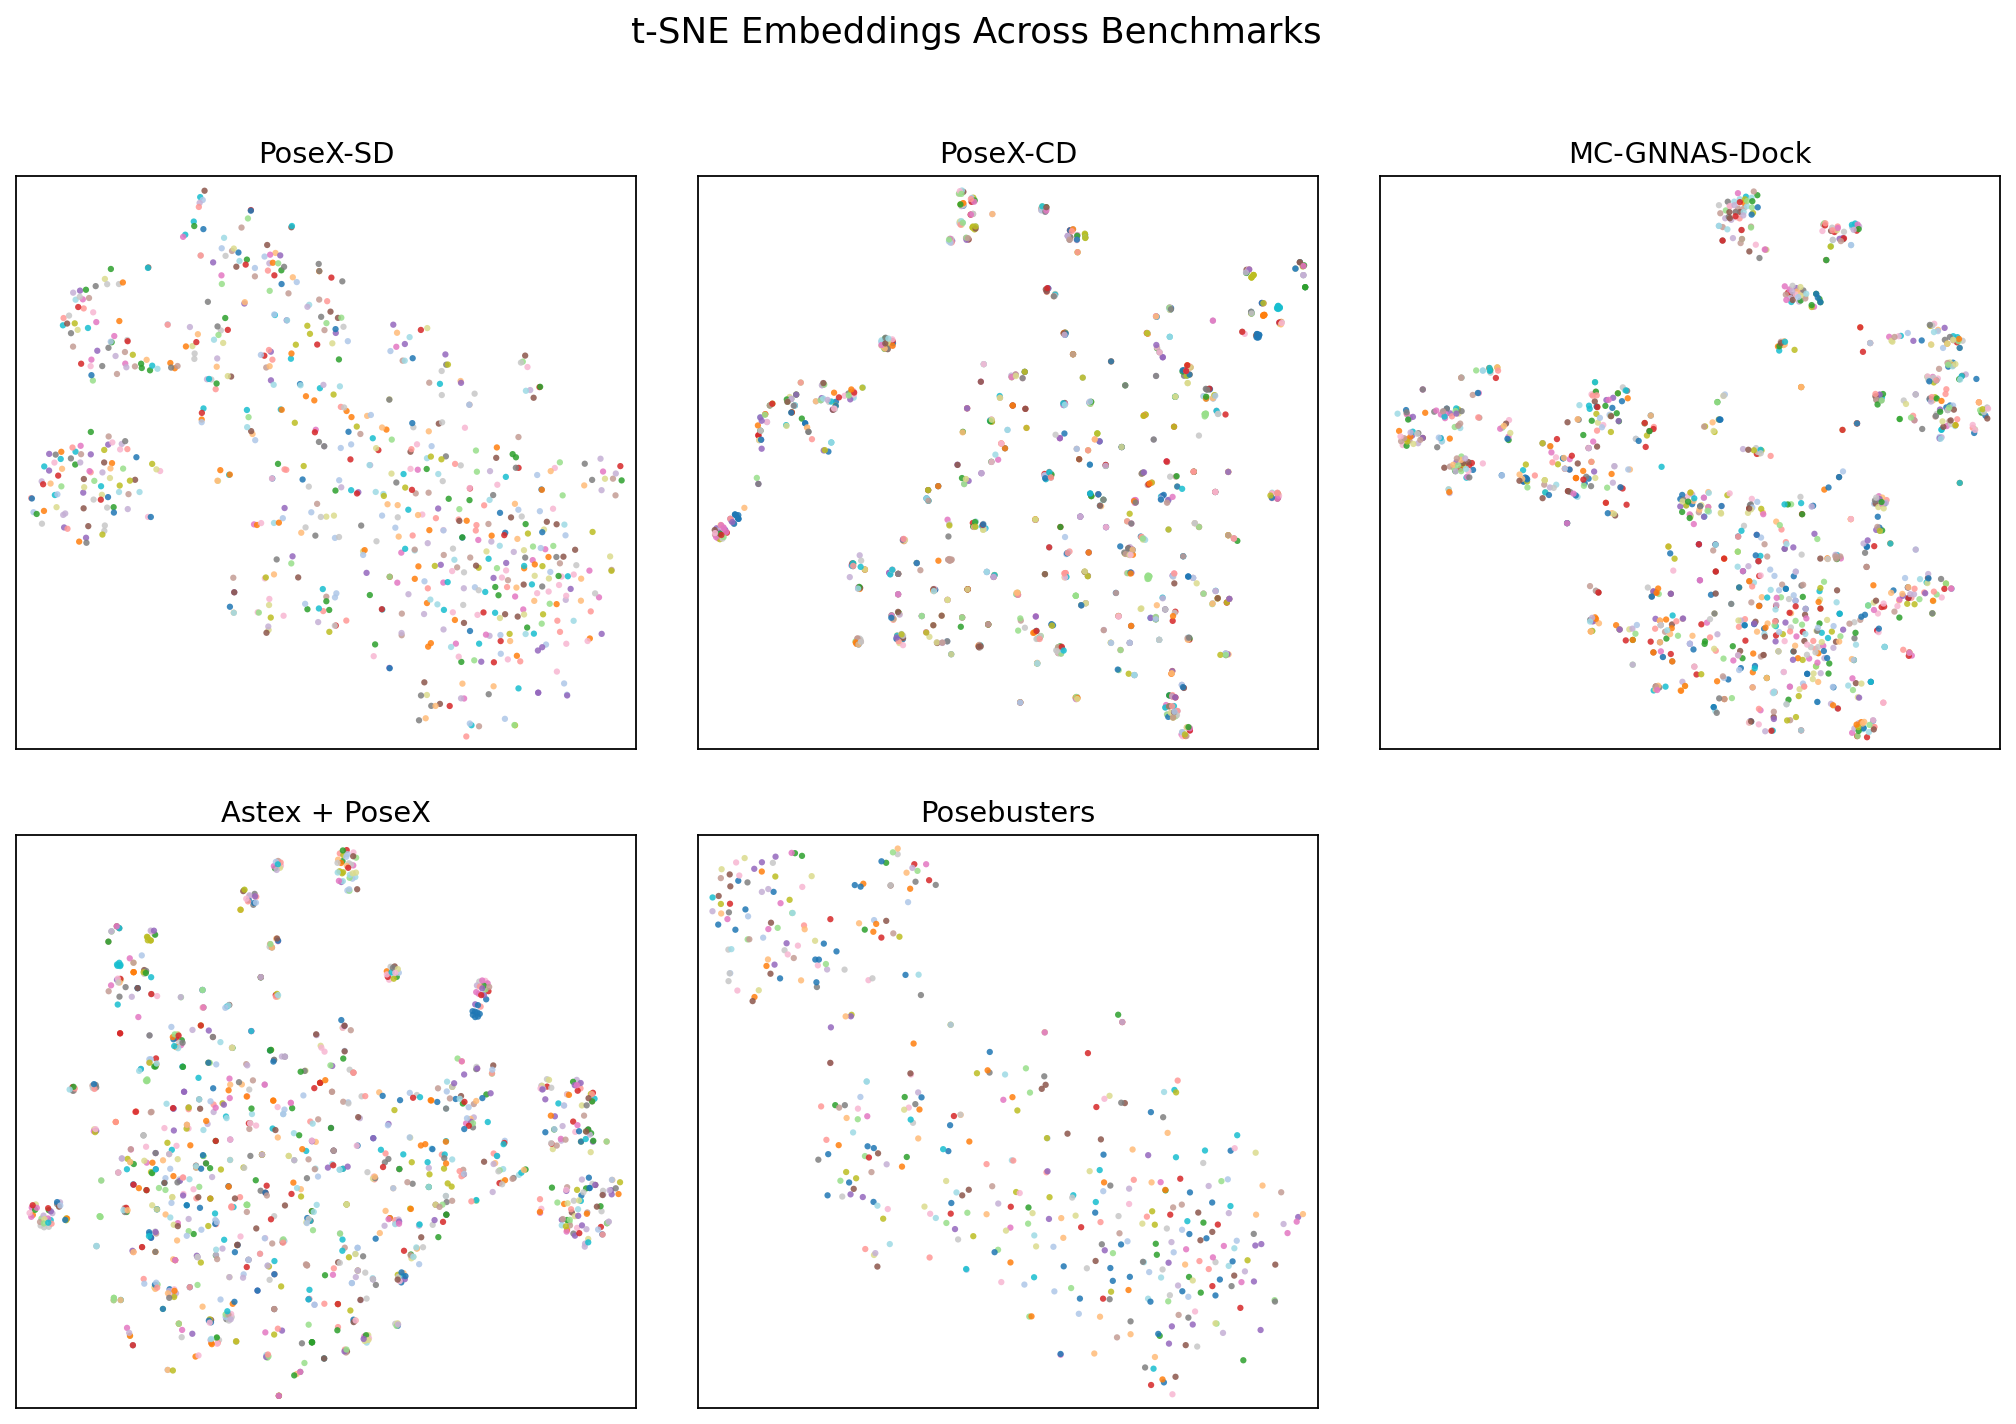

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_tsne(X, df, color_field="oracle", n_pca=50, max_points=1200, seed=0):
    X = np.asarray(X, dtype=np.float32)

    # Subsample
    if len(X) > max_points:
        rng = np.random.RandomState(seed)
        idx = rng.choice(len(X), max_points, replace=False)
        X = X[idx]
        df = df.iloc[idx].reset_index(drop=True)

    # PCA + t-SNE
    X_pca = PCA(n_components=min(n_pca, X.shape[1])).fit_transform(X)
    Y = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init="pca",
        random_state=seed,
    ).fit_transform(X_pca)

    return Y, df[color_field].values


# -------------------------------------------------------
# Compute first (to pre-build a global set of categories)
# -------------------------------------------------------

datasets = {
    "PoseX-SD"      : (X_posexsd, df_posexsd),
    "PoseX-CD"      : (X_posexcd, df_posexcd),
    "MC-GNNAS-Dock" : (X_moad, df_moad),
    "Astex + PoseX" : (X_astex_posex, df_astex_posex),
    "Posebusters"   : (X_posebusters, df_posebusters),
}

tsne_results = {}
all_labels = []

for name, (X, df) in datasets.items():
    Y, labels = compute_tsne(X, df)
    tsne_results[name] = (Y, labels)
    all_labels.extend(labels)

# unique global label set → consistent colouring
unique_labels = np.unique(all_labels)
palette = sns.color_palette("tab20", len(unique_labels))
label_to_color = {lab: palette[i] for i, lab in enumerate(unique_labels)}


# -------------------------------------------------------
# Elegant 2×3 figure layout
# -------------------------------------------------------

fig, axes = plt.subplots(
    nrows=2, ncols=3,
    figsize=(16, 10),
    dpi=160,
    gridspec_kw=dict(
        wspace=0.10,
        hspace=0.15,
    )
)

axes = axes.flatten()
titles = list(tsne_results.keys())

for ax, title in zip(axes, titles):
    Y, labels = tsne_results[title]

    colors = [label_to_color[l] for l in labels]

    ax.scatter(
        Y[:, 0], Y[:, 1],
        c=colors,
        s=8,
        linewidths=0,
        alpha=0.85,
    )

    ax.set_title(title, fontsize=13, pad=6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(Y[:, 0].min()*1.05, Y[:, 0].max()*1.05)
    ax.set_ylim(Y[:, 1].min()*1.05, Y[:, 1].max()*1.05)

# remove empty 6th panel if needed
if len(titles) < 6:
    axes[-1].axis("off")

# -------------------------------------------------------
# Shared legend (outside the grid)
# -------------------------------------------------------

# global title (optional)
fig.suptitle("t-SNE Embeddings Across Benchmarks", fontsize=16, y=0.98)

plt.show()


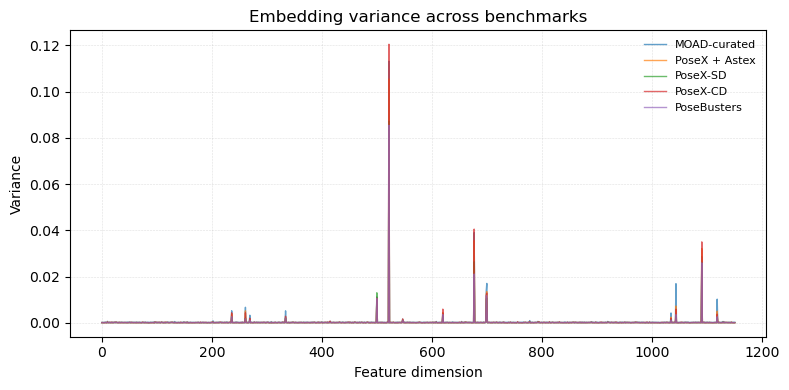

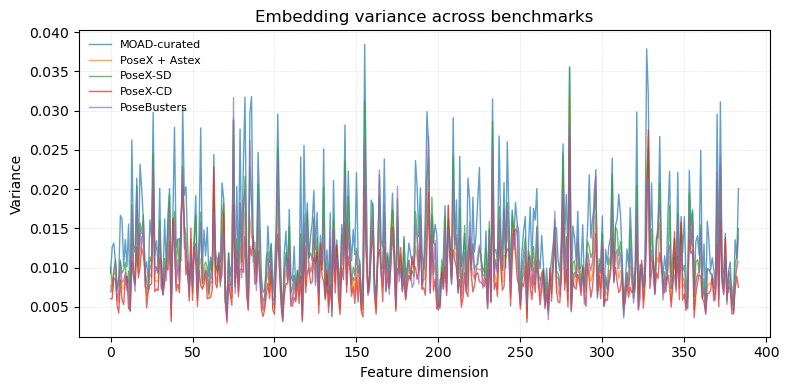

{'MOAD-curated': 3.305509090423584, 'PoseX + Astex': 2.7092196941375732, 'PoseX-SD': 2.960343360900879, 'PoseX-CD': 2.4313805103302, 'PoseBusters': 2.9815280437469482}


/tmp/ipykernel_3368855/24683376.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=30, ha="right")


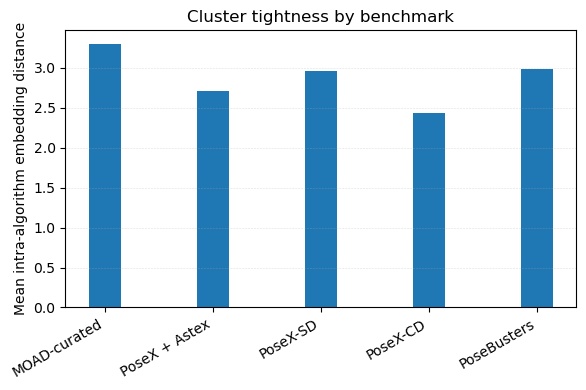

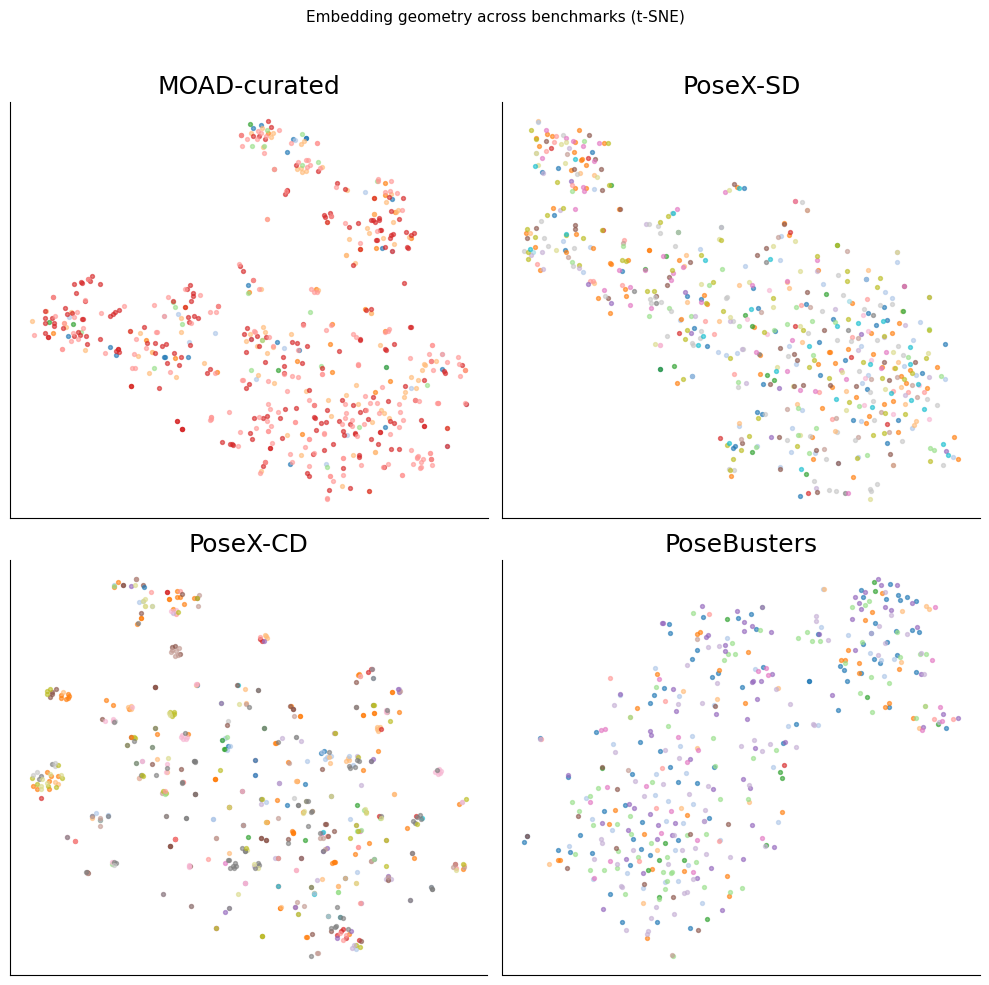

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

# ---------------------------------------------------------
# 0. Prepare your data
# ---------------------------------------------------------
# For each benchmark, you need:
#   X:  [N_i, D] pooled embeddings (protein+ligand)
#   algo: length-N_i array / Series of algorithm names (strings)
#
# Replace the np.load / pd.read_* with your real loading code.

benchmarks = {}

# ---- Example wiring (edit paths / columns) ----
# 1) MOAD-curated
X_moad = X_moad
df_moad = df_moad
alg_moad = df_moad["oracle_choose"].to_numpy()        # or whatever column is the algorithm ID
benchmarks["MOAD-curated"] = {"X": X_moad, "algo": alg_moad, 'df': df_moad}

# 2) PoseX + Astex
X_px_ast = X_astex_posex
df_px_ast = df_astex_posex
alg_px_ast = df_px_ast["oracle_choose"].to_numpy()
benchmarks["PoseX + Astex"] = {"X": X_px_ast, "algo": alg_px_ast, 'df': df_px_ast}

# 3) PoseX-SD
X_px_sd = X_posexsd
df_px_sd = df_posexsd
alg_px_sd = df_px_sd["oracle_choose"].to_numpy()
benchmarks["PoseX-SD"] = {"X": X_px_sd, "algo": alg_px_sd, 'df': df_px_sd}

# 4) PoseX-CD
X_px_cd = X_posexcd
df_px_cd = df_posexcd   
alg_px_cd = df_px_cd["oracle_choose"].to_numpy()
benchmarks["PoseX-CD"] = {"X": X_px_cd, "algo": alg_px_cd, 'df': df_px_cd}

# 5) PoseBusters
X_pb = X_posebusters
df_pb = df_posebusters
alg_pb = df_pb["oracle_choose"].to_numpy()
benchmarks["PoseBusters"] = {"X": X_pb, "algo": alg_pb, 'df': df_pb}

# ---------------------------------------------------------
# 1. Helper: mean intra-algorithm distance (cluster tightness)
# ---------------------------------------------------------
def mean_intra_algorithm_distance(X, labels):
    """Average pairwise distance within each algorithm cluster, 
    then averaged across algorithms (unweighted)."""
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    per_alg_means = []

    for a in uniq:
        idx = labels == a
        if idx.sum() < 2:
            continue
        Xi = X[idx]
        D = pairwise_distances(Xi)
        # use upper triangle (excluding diagonal)
        triu = np.triu_indices_from(D, k=1)
        per_alg_means.append(D[triu].mean())

    if not per_alg_means:
        return np.nan
    return float(np.mean(per_alg_means))

# ---------------------------------------------------------
# 2. (A) Embedding variance across feature dimensions
# ---------------------------------------------------------
plt.figure(figsize=(8, 4))
for name, data in benchmarks.items():
    X = data["X"][:, :1152]
    var = X.var(axis=0)
    plt.plot(var, label=name, linewidth=1.0, alpha=0.7)

plt.xlabel("Feature dimension")
plt.ylabel("Variance")
plt.title("Embedding variance across benchmarks")
plt.legend(frameon=False, fontsize=8)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
plt.tight_layout()
# plt.yscale('log')
plt.show()

plt.figure(figsize=(8, 4))
for name, data in benchmarks.items():
    X = data["X"][:, 1152:]
    var = X.var(axis=0)
    plt.plot(var, label=name, linewidth=1.0, alpha=0.7)

plt.xlabel("Feature dimension")
plt.ylabel("Variance")
plt.title("Embedding variance across benchmarks")
plt.legend(frameon=False, fontsize=8)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
plt.tight_layout()
# plt.yscale('log')
plt.show()

# ---------------------------------------------------------
# 3. (B) Cluster tightness barplot
# ---------------------------------------------------------
tightness = {}
for name, data in benchmarks.items():
    X = data["X"]
    labels = data["algo"]
    tightness[name] = mean_intra_algorithm_distance(X, labels)
print(tightness)
fig, ax = plt.subplots(figsize=(6, 4))
names = list(tightness.keys())
vals = [tightness[n] for n in names]
ax.bar(names, vals, width=0.3)
ax.set_ylabel("Mean intra-algorithm embedding distance")
ax.set_title("Cluster tightness by benchmark")
ax.set_xticklabels(names, rotation=30, ha="right")
ax.grid(True, axis="y", linestyle="--", linewidth=0.4, alpha=0.4)
fig.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. (C) t-SNE for all benchmarks (2×3 grid)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

perplexity = 30
n_iter = 1000

benchmarks_without_posex_ast = {k: v for k, v in benchmarks.items() if k != "PoseX + Astex"}
for ax, (name, data) in zip(axes, benchmarks_without_posex_ast.items()):

    random_state = 0
    emb = data["X"]
    oracle = data["algo"]

    # subsample for clarity if necessary
    if len(emb) > 600:
        idx = np.random.RandomState(random_state).choice(len(emb), size=600, replace=False)
        emb = emb[idx]
        oracle = oracle[idx]

    tsne = TSNE(
        n_components=2,
        perplexity=min(30, len(emb) - 1),
        learning_rate="auto",
        init="pca",
        random_state=random_state,
    )
    Z = tsne.fit_transform(emb)
    

    # colour by oracle algorithm (many colours, but that’s fine for structure)
    unique_algos = np.unique(oracle)
    cmap = plt.get_cmap("tab20")
    for i, algo in enumerate(unique_algos):
        m = (oracle == algo)
        ax.scatter(
            Z[m, 0], Z[m, 1],
            s=8,
            alpha=0.6,
            color=cmap(i % 20),
            label=algo if i < 10 else None,  # avoid crazy legend
        )
    ax.set_title(f"{name}", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Turn off any unused axes if < 6 benchmarks
for j in range(len(benchmarks), len(axes)):
    if name == "PoseX + Astex":
        continue
    axes[j].axis("off")

fig.suptitle("Embedding geometry across benchmarks (t-SNE)", fontsize=11)
fig.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
plt.savefig("tsne_benchmarks.pdf")


/tmp/ipykernel_3368855/1429162130.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Paired", 5)


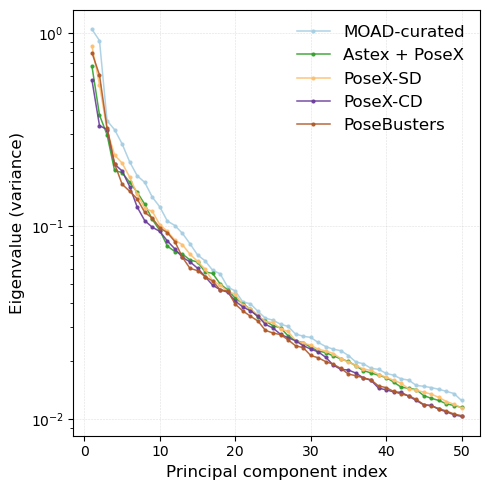

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ======================================================================
# 1. Fill in your data here
# ======================================================================
# Example keys: adjust to your actual benchmark names
embeddings = {
    "MOAD-curated": X_moad,          # shape (N_moad, D)
    "Astex + PoseX": X_astex_posex,  # shape (N_mix, D)
    "PoseX-SD": X_posexsd,          # shape (N_sd, D)
    "PoseX-CD": X_posexcd,          # shape (N_cd, D)
    "PoseBusters": X_posebusters,    # shape (N_pb, D)
}

n_components_to_plot = 50  # or min(D, 50)

# ======================================================================
# 2. Compute eigenvalue spectra via PCA
# ======================================================================
spectra = {}  # benchmark -> array of eigenvalues

for name, X in embeddings.items():
    # (Optional) centre features; PCA will centre anyway, but this is explicit
    X = np.asarray(X, dtype=np.float32)
    pca = PCA(n_components=min(n_components_to_plot, X.shape[1]), svd_solver="full")
    pca.fit(X)
    spectra[name] = pca.explained_variance_  # eigenvalues (not variance ratio)

# ======================================================================
# 3. Plot: eigenvalue decay
# ======================================================================
plt.figure(figsize=(5, 5))
cmap = get_cmap("Paired", 5)
for i, (name, eigvals) in enumerate(spectra.items()):
    k = len(eigvals)
    xs = np.arange(1, k + 1)
    plt.plot(xs, eigvals, marker="o", markersize=2, linewidth=1.1, label=name, alpha=0.9, color=cmap(i))
    
plt.yscale("log")
plt.xlabel("Principal component index", fontsize=12)
plt.ylabel("Eigenvalue (variance)", fontsize=12)
# plt.title("PCA spectral decay of pooled embeddings")
plt.legend(frameon=False, fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
plt.tight_layout()
# plt.show()
plt.savefig("pca_spectral_decay.pdf")


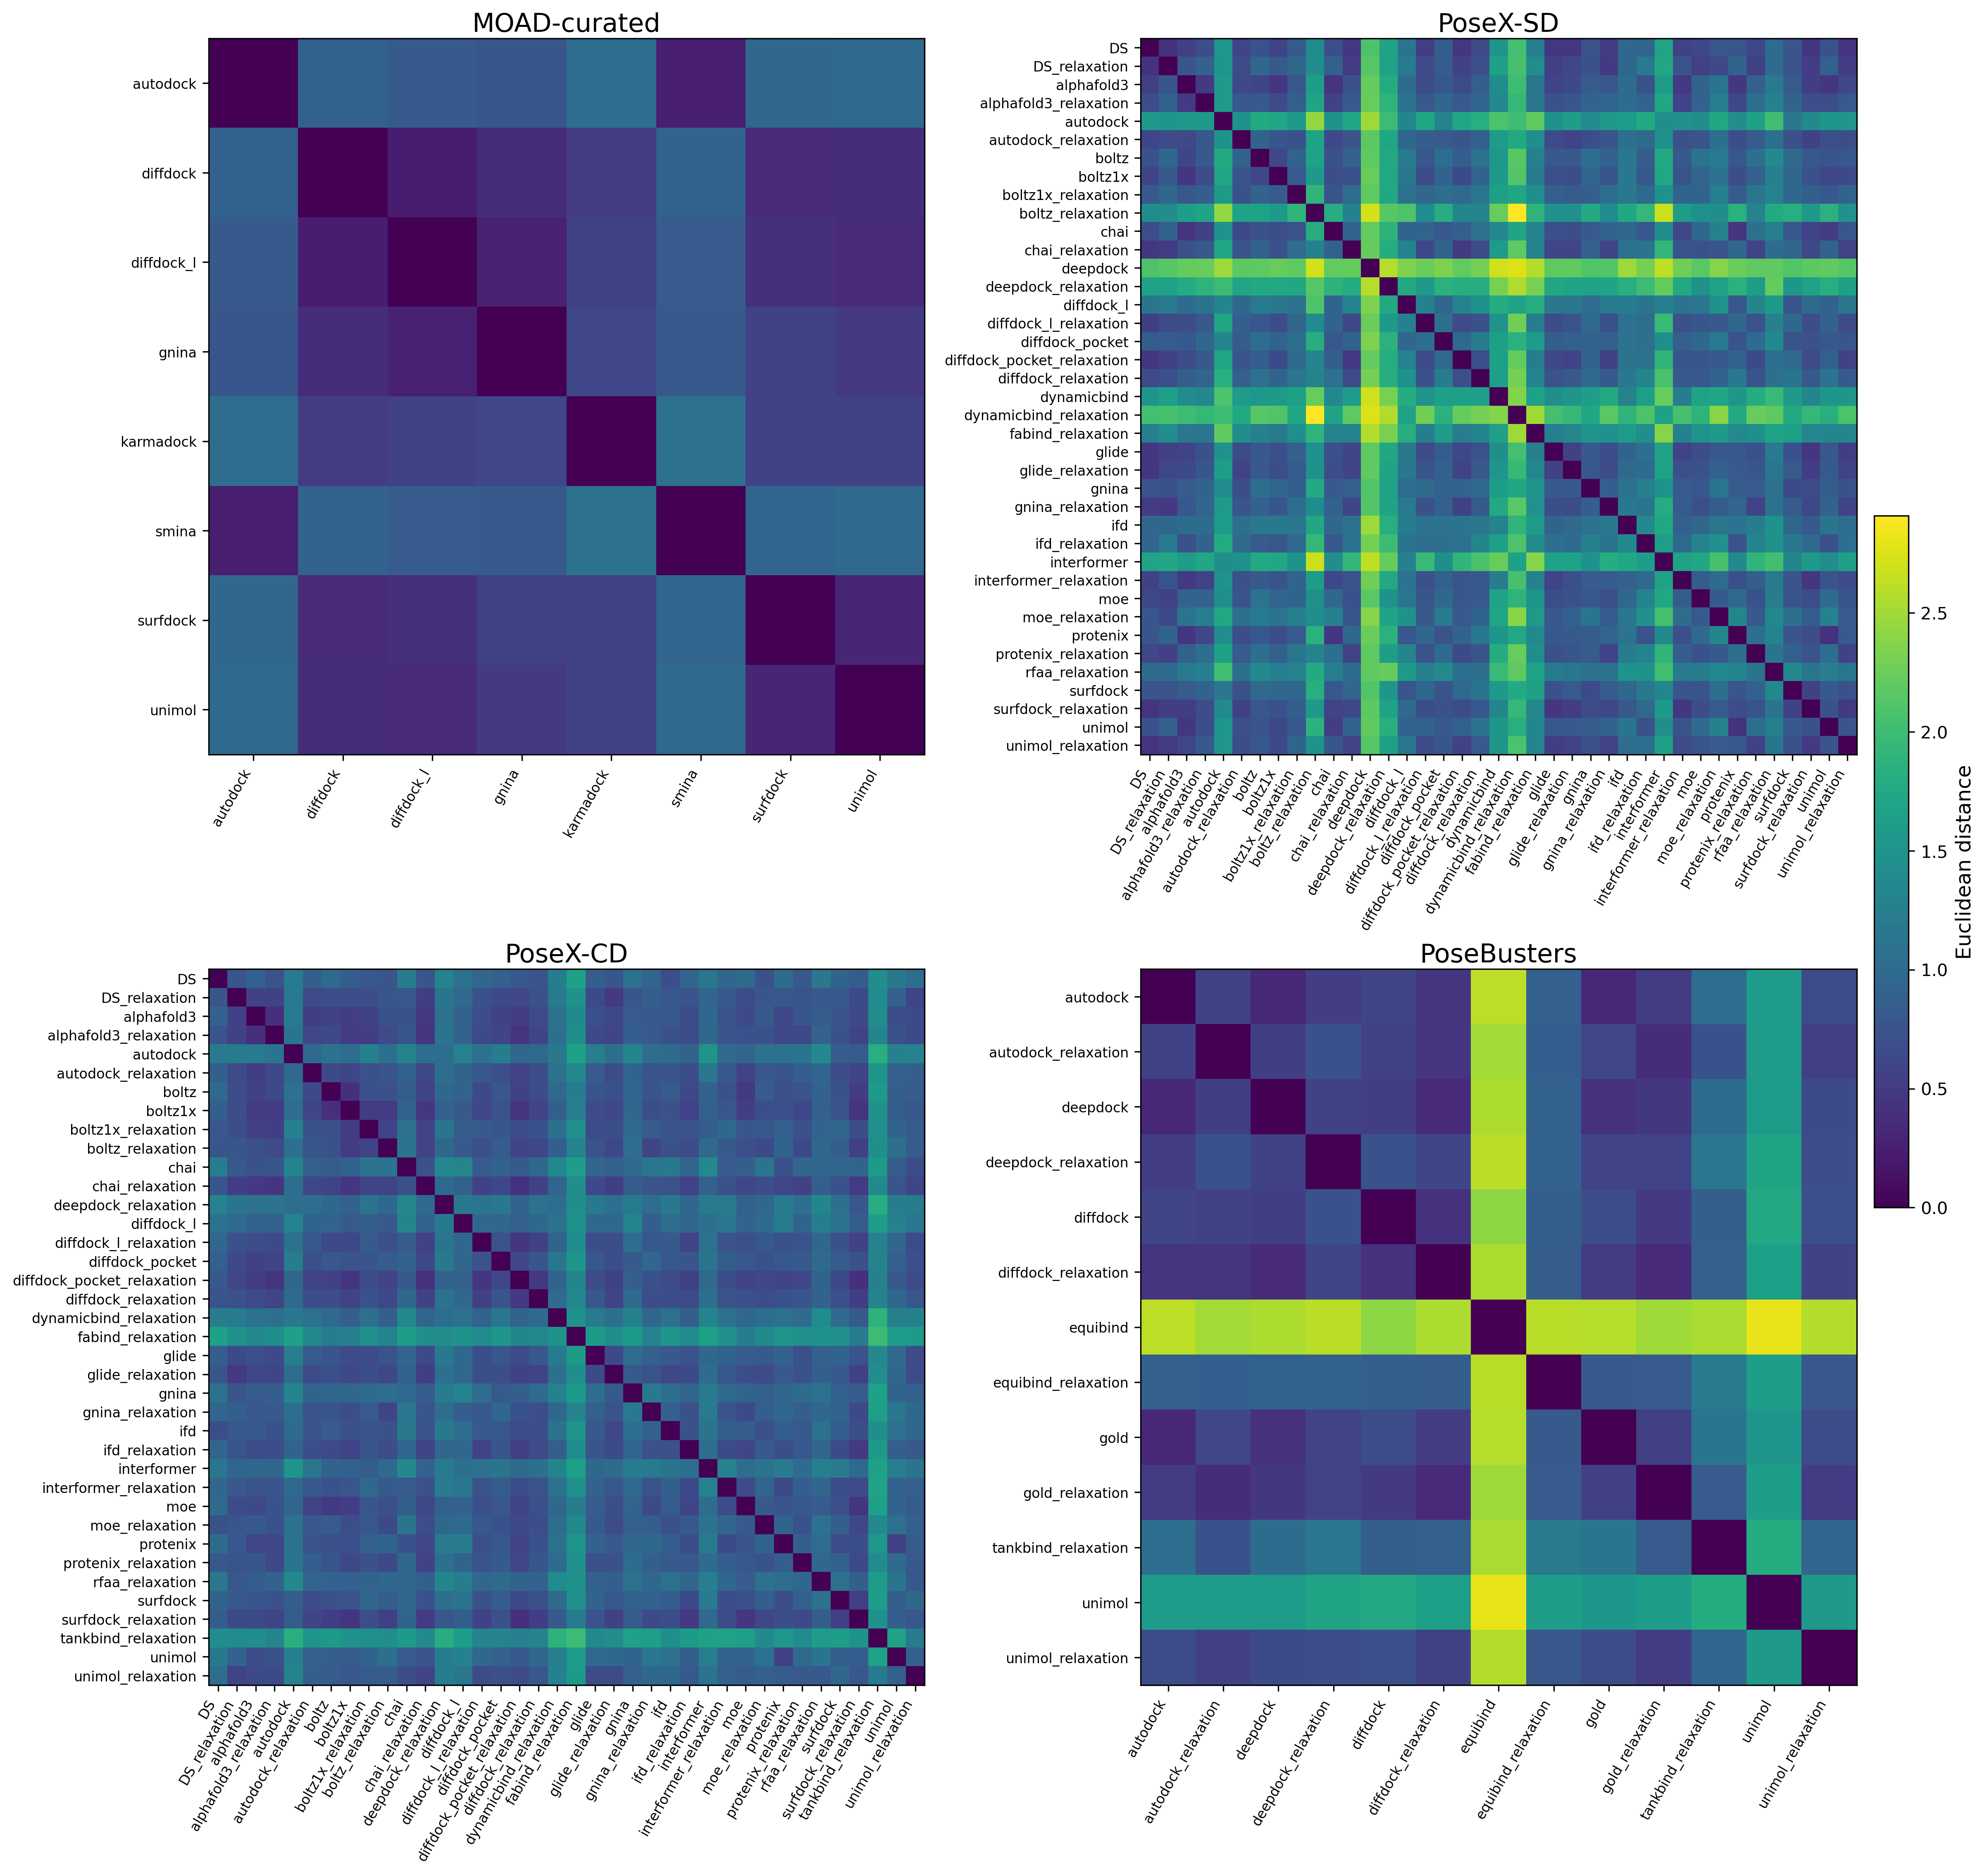

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import matplotlib.transforms as mtransforms

def standardize_margins(fig, ax, left=0.12, right=0.88, bottom=0.12, top=0.88):
    """
    Fix margins AFTER drawing text.
    ax is the main heatmap axis.
    """

    fig.canvas.draw()   # Must draw once to get accurate text extents

    # Get bounding box of the drawn axes (in figure coordinates)
    renderer = fig.canvas.get_renderer()
    bbox = ax.get_tightbbox(renderer).transformed(fig.transFigure.inverted())

    # Compute required scaling to force same margins
    dx_left   = bbox.x0 - left
    dx_right  = right - bbox.x1
    dy_bottom = bbox.y0 - bottom
    dy_top    = top - bbox.y1

    # Shift everything so that bbox matches desired margins
    ax.set_position([
        bbox.x0 - dx_left,
        bbox.y0 - dy_bottom,
        bbox.width + dx_left + dx_right,
        bbox.height + dy_bottom + dy_top
    ])

algo_labels = {
    "MOAD-curated": alg_moad,
    "PoseX + Astex": alg_px_ast,
    "PoseX-SD": alg_px_sd,
    "PoseX-CD": alg_px_cd,
    "PoseBusters": alg_pb,
}

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

benchmark_names = ['MOAD-curated', 'PoseX-SD', 'PoseX-CD', 'PoseBusters']
n = len(benchmark_names)

# Choose grid size (square-ish)
cols = 2
rows = 3

fig = plt.figure(figsize=(9*cols, 9*rows), dpi=300)

# Create a GridSpec with tight, equal-sized subplots
gs = fig.add_gridspec(
    rows, cols,
    wspace=0.25, hspace=0.30    # tweak spacing between panels
)

# Storage for imshow handles to sync color scales
all_dist_values = []

# First pass: compute all distance matrices first
dist_matrices = {}
algo_lists = {}

for name in benchmark_names:
    X = np.asarray(embeddings[name], dtype=np.float32)
    labels = np.asarray(algo_labels[name])

    algos = np.sort(np.unique(labels))
    centroids = [X[np.where(labels == a)[0]].mean(axis=0) for a in algos]
    centroids = np.vstack(centroids)

    dist_mat = pairwise_distances(centroids, centroids, metric="euclidean")
    dist_matrices[name] = dist_mat
    algo_lists[name] = algos
    all_dist_values.append(dist_mat)

# Shared vmin/vmax across all heatmaps
all_vals = np.concatenate([m.flatten() for m in all_dist_values])
vmin, vmax = all_vals.min(), all_vals.max()

# Second pass: plotting
axs = []
ims = []

for idx, name in enumerate(benchmark_names):
    r, c = divmod(idx, cols)
    ax = fig.add_subplot(gs[r, c])
    axs.append(ax)

    mat = dist_matrices[name]
    algos = algo_lists[name]

    im = ax.imshow(
        mat,
        cmap="viridis",
        aspect="equal",
        interpolation="nearest",
        vmin=vmin,
        vmax=vmax
    )
    ims.append(im)

    # Ticks
    ax.set_xticks(np.arange(len(algos)))
    ax.set_yticks(np.arange(len(algos)))
    ax.set_xticklabels(algos, rotation=60, ha="right", fontsize=8)
    ax.set_yticklabels(algos, fontsize=8)

    # Titles
    ax.set_title(name, fontsize=15, pad=4)

# Shared colorbar
cbar = fig.colorbar(
    ims[0],
    ax=axs,
    fraction=0.02,
    pad=0.01
)
# Location at the 6-th 
cbar.set_label("Euclidean distance", fontsize=12)

# plt.show()

plt.savefig("centroid_distance.pdf")


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# ======================================================================
# 1. Silhouette scores per benchmark
# ======================================================================
silh_scores = {}
for name, X in embeddings.items():
    X = np.asarray(X, dtype=np.float32)
    labels = np.asarray(algo_labels[name])

    # Need at least 2 distinct algorithms with >=2 samples to compute silhouette
    unique_algos, counts = np.unique(labels, return_counts=True)
    valid_algos = unique_algos[counts >= 2]
    mask = np.isin(labels, valid_algos)

    X_valid = X[mask]
    labels_valid = labels[mask]

    if len(np.unique(labels_valid)) < 2:
        silh_scores[name] = np.nan
        continue

    score = silhouette_score(X_valid, labels_valid, metric="euclidean")
    silh_scores[name] = score

# ======================================================================
# 2. Plot bar chart
# ======================================================================
names = list(silh_scores.keys())
vals = [silh_scores[n] for n in names]

fig, ax = plt.subplots(figsize=(5.5, 3))
ax.bar(range(len(names)), vals)
print(vals)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=30, ha="right")
ax.set_ylabel("Silhouette score")
ax.set_title("Algorithm cluster separability in embedding space")

ax.axhline(0.0, color="black", linewidth=0.6)
plt.tight_layout()
plt.show()
# plt.savefig("silhouette_scores_benchmarks.pdf")


KeyError: 'Astex + PoseX'

Oracle scores (mean best-algorithm performance):
  MOAD-curated   : 0.8671
  PoseX + Astex  : 0.9555
  PoseX-SD       : 0.9715
  PoseX-CD       : 0.9442
  PoseBusters    : 0.7633

Oracle entropies (bits):
  MOAD-curated   : 2.395
  PoseX + Astex  : 4.699
  PoseX-SD       : 4.675
  PoseX-CD       : 4.590
  PoseBusters    : 3.205

Pairwise MMD^2 between benchmarks:
               MOAD-curated  PoseX + Astex  PoseX-SD  PoseX-CD  PoseBusters
MOAD-curated         0.0000         0.0757    0.0337    0.1106       0.0427
PoseX + Astex        0.0757         0.0000    0.0162    0.0084       0.0250
PoseX-SD             0.0337         0.0162    0.0000    0.0388       0.0058
PoseX-CD             0.1106         0.0084    0.0388    0.0000       0.0494
PoseBusters          0.0427         0.0250    0.0058    0.0494       0.0000


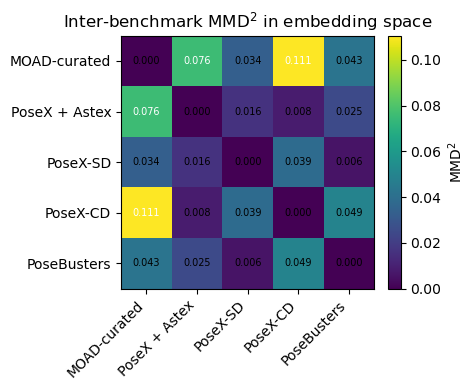

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 0. INPUTS YOU MUST PROVIDE
# ----------------------------------------------------------------------
# Example placeholders – replace with your actual objects.
# benchmark_dfs: each df has one row per complex, and algo_cols are 0/1 success flags or scores.
benchmark_dfs = {
    "MOAD-curated": df_moad,
    "PoseX + Astex": df_astex_posex,
    "PoseX-SD": df_posexsd,
    "PoseX-CD": df_posexcd,
    "PoseBusters": df_posebusters,
}

# For each benchmark, list the columns that store per-algorithm performance
algo_cols = {
    "MOAD-curated":   benchmarks['MOAD-curated']['df'].columns[2:-7].tolist(),  # e.g. all algo score columns
    "PoseX + Astex":  benchmarks['PoseX + Astex']['df'].columns[2:-7].tolist(),
    "PoseX-SD":       benchmarks['PoseX-SD']['df'].columns[2:-7].tolist(),
    "PoseX-CD":       benchmarks['PoseX-CD']['df'].columns[2:-7].tolist(),
    "PoseBusters":    benchmarks['PoseBusters']['df'].columns[2:-7].tolist(),
}

# Embeddings: pooled protein+ligand embeddings per benchmark (N_i, d)
embeddings = {
    "MOAD-curated": X_moad,
    "PoseX + Astex": X_astex_posex,
    "PoseX-SD": X_posexsd,
    "PoseX-CD": X_posexcd,
    "PoseBusters": X_posebusters,
}

# ----------------------------------------------------------------------
# 1. Oracle score and oracle entropy per benchmark
# ----------------------------------------------------------------------

def compute_oracle_stats(df: pd.DataFrame, algo_cols):
    """
    df[algo_cols] are per-algorithm scores or success flags (higher = better).
    Returns:
      oracle_score: mean of best-algorithm score per instance
      oracle_entropy_bits: Shannon entropy (bits) of the oracle's choice distribution.
                           Ties are handled by fractional counting.
    """
    scores = df[algo_cols].to_numpy()          # shape (N, A)
    # Oracle score per instance
    best_scores = scores.max(axis=1)           # (N,)
    oracle_score = float(best_scores.mean())

    # Oracle choice distribution with fractional tie-handling
    N, A = scores.shape
    counts = np.zeros(A, dtype=float)

    for i in range(N):
        row = scores[i]
        mx = row.max()
        winners = np.where(row == mx)[0]
        w = len(winners)
        counts[winners] += 1.0 / w            # split 1 sample equally across ties

    probs = counts / counts.sum()
    probs = probs[probs > 0]
    oracle_entropy_bits = float(-(probs * np.log2(probs)).sum())

    return oracle_score, oracle_entropy_bits


oracle_scores = {}
oracle_entropies = {}

for name, df in benchmark_dfs.items():
    s, h = compute_oracle_stats(df, algo_cols[name])
    oracle_scores[name] = s
    oracle_entropies[name] = h

print("Oracle scores (mean best-algorithm performance):")
for k, v in oracle_scores.items():
    print(f"  {k:15s}: {v:.4f}")

print("\nOracle entropies (bits):")
for k, v in oracle_entropies.items():
    print(f"  {k:15s}: {v:.3f}")

# ----------------------------------------------------------------------
# 2. Pairwise MMD between benchmarks (heatmap)
# ----------------------------------------------------------------------

def gaussian_mmd(X, Y, sigma=None, max_samples=2000, random_state=0):
    """
    Biased MMD^2 with RBF kernel.
    X: (n_x, d), Y: (n_y, d)
    sigma: bandwidth. If None, use median heuristic on a pooled subsample.
    """
    rng = np.random.RandomState(random_state)

    # Optional subsampling to keep complexity manageable
    if X.shape[0] > max_samples:
        X = X[rng.choice(X.shape[0], max_samples, replace=False)]
    if Y.shape[0] > max_samples:
        Y = Y[rng.choice(Y.shape[0], max_samples, replace=False)]

    n, m = X.shape[0], Y.shape[0]

    # Choose bandwidth
    if sigma is None:
        Z = np.vstack([X, Y])
        # sample subset for median heuristic
        if Z.shape[0] > max_samples:
            Z = Z[rng.choice(Z.shape[0], max_samples, replace=False)]
        # pairwise distances
        dists = np.sum((Z[:, None, :] - Z[None, :, :])**2, axis=-1)
        # take median of upper triangle (exclude zeros)
        tri = dists[np.triu_indices_from(dists, k=1)]
        med = np.median(tri)
        sigma = np.sqrt(0.5 * med + 1e-12)

    gamma = 1.0 / (2.0 * sigma**2)

    def k(xx, yy):
        return np.exp(-gamma * np.sum((xx[:, None, :] - yy[None, :, :])**2, axis=-1))

    Kxx = k(X, X)
    Kyy = k(Y, Y)
    Kxy = k(X, Y)

    # Biased MMD^2 estimator
    mmd2 = Kxx.mean() + Kyy.mean() - 2.0 * Kxy.mean()
    return float(mmd2)


bench_names = list(embeddings.keys())
B = len(bench_names)
mmd_matrix = np.zeros((B, B))

for i in range(B):
    for j in range(B):
        if i == j:
            mmd_matrix[i, j] = 0.0
        elif i < j:
            mmd = gaussian_mmd(embeddings[bench_names[i]], embeddings[bench_names[j]])
            mmd_matrix[i, j] = mmd
            mmd_matrix[j, i] = mmd

print("\nPairwise MMD^2 between benchmarks:")
print(pd.DataFrame(mmd_matrix, index=bench_names, columns=bench_names).round(4))

# ----------------------------------------------------------------------
# 3. Plot MMD heatmap
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(mmd_matrix, cmap="viridis")

ax.set_xticks(range(B))
ax.set_yticks(range(B))
ax.set_xticklabels(bench_names, rotation=45, ha="right")
ax.set_yticklabels(bench_names)

for i in range(B):
    for j in range(B):
        ax.text(j, i, f"{mmd_matrix[i, j]:.3f}",
                ha="center", va="center", fontsize=7, color="white" if mmd_matrix[i,j] < mmd_matrix.max()/2 else "black")

ax.set_title("Inter-benchmark MMD$^2$ in embedding space")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("MMD$^2$")
fig.tight_layout()
plt.show()


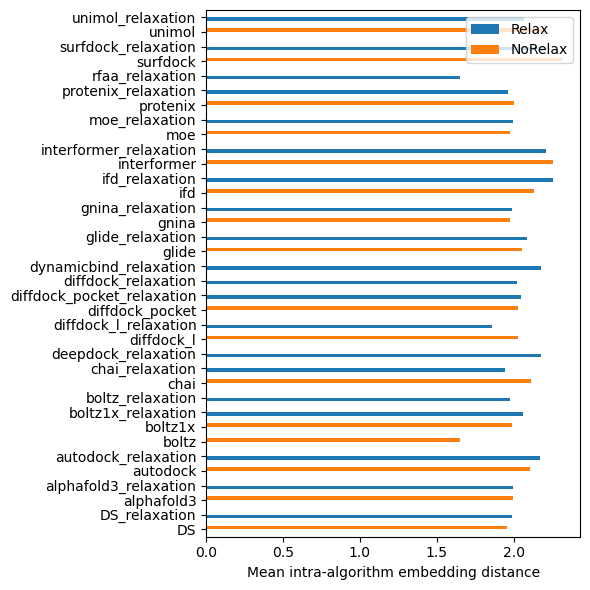

: 

: 

In [ ]:
def within_class_dispersion(X, df):
    disp = {}
    for alg, idx in df.groupby("oracle_choose").groups.items():
        if len(idx) < 5: continue
        X_alg = X[idx]
        center = X_alg.mean(axis=0)
        disp[alg] = np.linalg.norm(X_alg - center, axis=1).mean()
    return pd.Series(disp).sort_values(ascending=False)

disp_relax = within_class_dispersion(X_relax, df_relax)
disp_norelax = within_class_dispersion(X_norelax, df_no_relax)
disp_df = pd.DataFrame({"Relax": disp_relax, "NoRelax": disp_norelax}).fillna(0)
disp_df.plot.barh(figsize=(6,6))
plt.xlabel("Mean intra-algorithm embedding distance")
plt.tight_layout(); plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors

def mmd(X1, X2):
    """Approximate Maximum Mean Discrepancy with RBF kernel."""
    sigma = np.median(np.linalg.norm(X1[:100]-X1[0], axis=1))
    def kernel(X,Y): 
        sq = np.sum((X[:,None,:]-Y[None,:,:])**2,axis=-1)
        return np.exp(-sq/(2*sigma**2))
    return np.mean(kernel(X1,X1)) + np.mean(kernel(X2,X2)) - 2*np.mean(kernel(X1,X2))

mmd_score = mmd(X_relax[:1000], X_norelax[:1000])
print(f"MMD (relax vs no-relax) ≈ {mmd_score:.4f}")

MMD (relax vs no-relax) ≈ 0.0010


: 

: 

In [ ]:
summary = pd.DataFrame({
    "Embedding_var": [v_relax, v_norelax],
    "Oracle_entropy": [H_relax, H_norelax],
    "Score_oracle_corr": [corr_relax, corr_norelax]
}, index=["Relax", "No-relax"])
summary["Var_ratio"] = summary.loc["Relax","Embedding_var"]/summary.loc["No-relax","Embedding_var"]
summary["Entropy_ratio"] = summary.loc["Relax","Oracle_entropy"]/summary.loc["No-relax","Oracle_entropy"]
summary.to_csv("representation_collapse_summary.csv")
print(summary.round(3))

          Embedding_var  Oracle_entropy  Score_oracle_corr  Var_ratio  \
Relax             0.003           3.931              0.484      0.995   
No-relax          0.003           3.757              0.516      0.995   

          Entropy_ratio  
Relax             1.046  
No-relax          1.046  


: 

: 

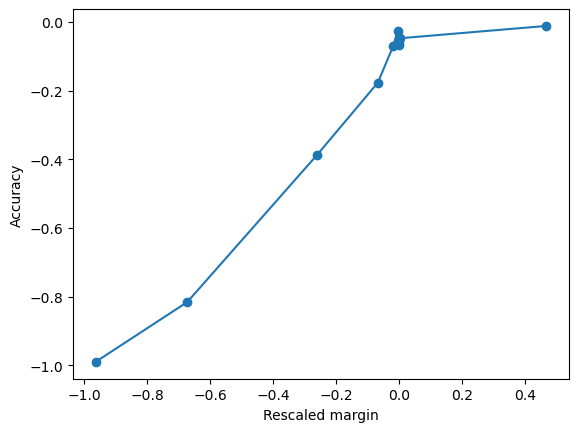

: 

: 

In [ ]:
# margin = (df_relax["AS"] - df_relax["SBS: surfdock_relaxation"])
margin = (df_relax["AS"] - df_relax["3rd"])
correct = df_relax["AS"] - df_relax["oracle"]
bins = np.quantile(margin, np.linspace(0,1,11))
acc = [correct[(margin>=bins[i]) & (margin<=bins[i+1])].mean() for i in range(10)]
plt.plot((bins[:-1]+bins[1:])/2, acc, marker="o"); plt.xlabel("Rescaled margin"); plt.ylabel("Accuracy"); plt.show()

<Axes: ylabel='oracle_choose'>

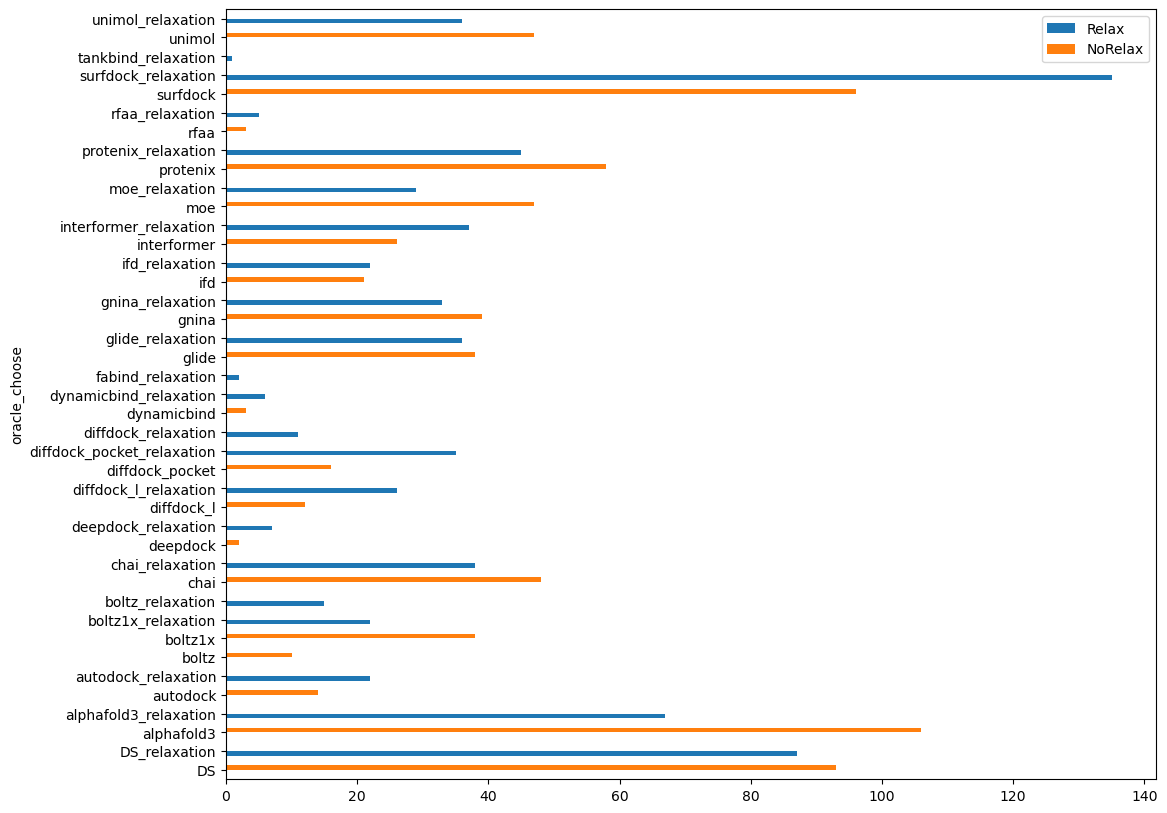

: 

: 

In [ ]:
# per-algorithm mean oracle score (for each regime)
mean_scores_relax = df_relax.groupby("oracle_choose")["oracle_choose"].count().sort_values(ascending=False)
mean_scores_norelax = df_no_relax.groupby("oracle_choose")["oracle_choose"].count().sort_values(ascending=False)
pd.DataFrame({"Relax": mean_scores_relax, "NoRelax": mean_scores_norelax}).fillna(0).plot.barh(figsize=(12, 10))

: 

: 